<center>
<h2>IMAGE CLASSIFICATION</h2>
<h3>(Rock paper scissors dataset)</h3>

---
By: Mohammad Damarjati Prasetyo

Dicoding username: [md-pras](https://www.dicoding.com/users/md-pras)
</center>

## Load libraries

In [ ]:
pip install split-folders

In [ ]:
import os
import time
import splitfolders
import matplotlib.pyplot as plt
import numpy as np
import random as rn
import pandas as pd
from google.colab import files
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras import callbacks
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img

## Data Preparation

In [ ]:
#Download dataset
!wget --no-check-certificate \
https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-24 12:55:36--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  5.82MB/s    in 36s     

2021-07-24 12:56:12 (8.60 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
#Extract zip file
!unzip '/tmp/rockpaperscissors.zip' -d '/tmp'

In [ ]:
#List directory
os.listdir('/tmp/rockpaperscissors')

['rock', 'README_rpc-cv-images.txt', 'rps-cv-images', 'scissors', 'paper']

In [ ]:
#Check the number of files
print('n rock: ', len(os.listdir('/tmp/rockpaperscissors/rock/')))
print('n paper: ', len(os.listdir('/tmp/rockpaperscissors/paper/')))
print('n scissors: ', len(os.listdir('/tmp/rockpaperscissors/scissors/')))

n rock:  726
n paper:  712
n scissors:  750


Found 2188 files belonging to 3 classes.


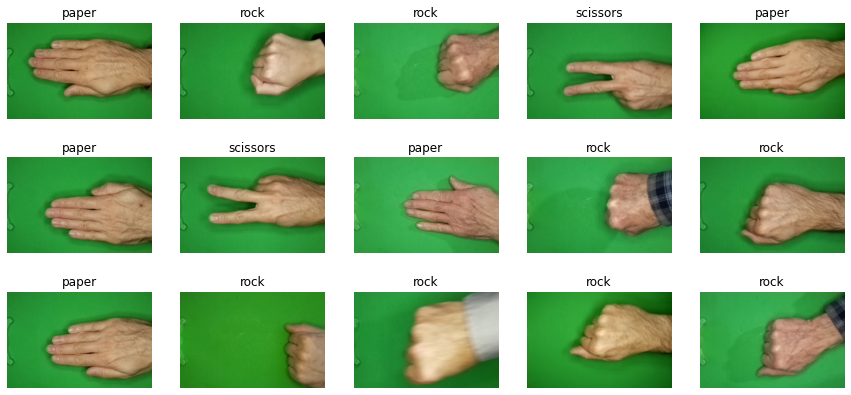

In [ ]:
#Preview some random images
random_img = tf.keras.preprocessing.image_dataset_from_directory('/tmp/rockpaperscissors/rps-cv-images', labels='inferred')

plt.figure(figsize=(15,7))
for i in range(15):
  plt.subplot(3,5,i+1)
  img_path = random_img.file_paths[i]
  image = plt.imread(img_path)
  plt.imshow(image)
  plt.title(os.path.basename(os.path.dirname(img_path)))
  plt.axis('off')

plt.show()

In [ ]:
#Split data into new directory (train:validation = 0.6:0.4)
os.mkdir('/tmp/rockpaperscissors/rps2')
base_dir = '/tmp/rockpaperscissors/rps2'

splitfolders.ratio('/tmp/rockpaperscissors/rps-cv-images', output=base_dir, 
                   seed=1, ratio=(.6, .4), group_prefix=None)

Copying files: 2188 files [00:00, 3549.30 files/s]


In [ ]:
#Check train:validation ratio
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

n_total = sum([len(files) for r, d, files in os.walk(base_dir)])
n_train = sum([len(files) for r, d, files in os.walk(train_dir)])
n_val = sum([len(files) for r, d, files in os.walk(val_dir)])

print('n train: {} ({}%)'.format(n_train, round(n_train*100/n_total, 2)))
print('n validation: {} ({}%)'.format(n_val, round(n_val*100/n_total, 2)))

n train: 1312 (59.96%)
n test: 876 (40.04%)


## Data Augmentation

In [ ]:
#Set some parameters
BATCH_SIZE = 32
IMG_SIZE = 80
NUM_CLASSES = 3

In [ ]:
#Train generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    rotation_range = 20,
    zoom_range = 0.2,
    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size =(IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    seed = 1,
    class_mode = 'categorical')

#Validation generator
val_datagen = ImageDataGenerator(
    rescale = 1./255)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = 1,
    class_mode = 'categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


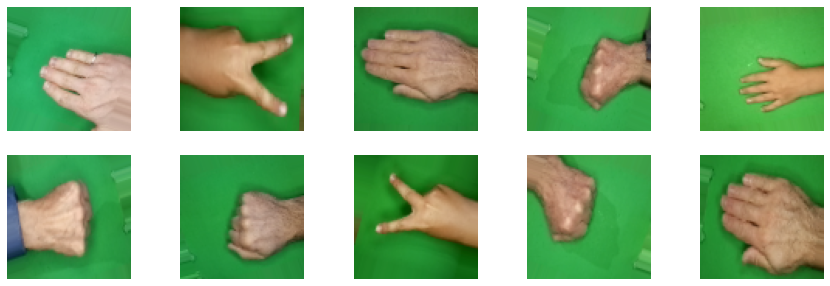

In [ ]:
#Preview some augmentation results
plt.figure(figsize=(15,5))
for i in range(10):
  plt.subplot(2,5,i+1)
  batch = train_generator.next()
  image = batch[0][0]
  plt.imshow(image)
  plt.axis('off')

plt.show()

## Modelling

* Using VGG16 pretrained model for transfer learning
* Fine tuning pretrained model (unfreezing some layers)
* Adding batch normalization layer to stabilize learning & speed up convergence time
* Adding dropout layer for regularization
* Using Stochastic Gradient Descent (SGD) optimizer with nesterov momentum
* Using callback to prevent overfitting (early stopping, checkpoint, custom callback)


In [ ]:
#Load VGG16 pretrained model
vgg_model = VGG16(weights = "imagenet", include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 20, 128)       0     

In [ ]:
# Unfreeze last 4 layers
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4b132d0490> False
<keras.layers.convolutional.Conv2D object at 0x7f4b12dedb50> False
<keras.layers.convolutional.Conv2D object at 0x7f4b09ffcb90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4b1240e190> False
<keras.layers.convolutional.Conv2D object at 0x7f4b728de950> False
<keras.layers.convolutional.Conv2D object at 0x7f4b122d1610> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4b12646110> False
<keras.layers.convolutional.Conv2D object at 0x7f4b13317290> False
<keras.layers.convolutional.Conv2D object at 0x7f4b09f4d590> False
<keras.layers.convolutional.Conv2D object at 0x7f4b730132d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4b12408ad0> False
<keras.layers.convolutional.Conv2D object at 0x7f4b13275750> False
<keras.layers.convolutional.Conv2D object at 0x7f4b12dfbcd0> False
<keras.layers.convolutional.Conv2D object at 0x7f4b127b5bd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4b13282490>

In [ ]:
#Set random seed
def reset_seed():
  os.environ['PYTHONHASHSEED'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  np.random.seed(1)
  rn.seed(1)
  tf.random.set_seed(1)

In [ ]:
#Add fully connected layers
reset_seed()
model = Sequential()
model.add(vgg_model)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization(momentum=0.01))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 15,241,027
Trainable params: 7,605,251
Non-trainable params: 7,635,776
___________________________________

In [ ]:
#Compile model
reset_seed()
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [ ]:
#Callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.99 and logs.get('val_accuracy') >= 0.999:
            self.model.stop_training = True

callback = CustomCallback()

early_stop = callbacks.EarlyStopping(
    monitor="val_accuracy", 
    patience=10, 
    restore_best_weights=True,)

checkpoint_filepath = '/tmp/model_checkpoint'
checkpoint = callbacks.ModelCheckpoint(
    checkpoint_filepath, 
    monitor="val_accuracy", 
    save_weights_only=True, 
    save_best_only=True)

In [ ]:
#Model fitting
start_time = time.time()
reset_seed()

history = model.fit(
    train_generator,
    epochs = 100,
    batch_size = BATCH_SIZE,
    callbacks = [callback, checkpoint, early_stop],
    validation_data = validation_generator,
    verbose =1)

end_time = time.time()-start_time

Epoch 1/100
41/41 [==============================] - 9s 185ms/step - loss: 0.3226 - accuracy: 0.8873 - val_loss: 0.0176 - val_accuracy: 0.9943
Epoch 2/100
41/41 [==============================] - 7s 168ms/step - loss: 0.0347 - accuracy: 0.9862 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 3/100
41/41 [==============================] - 7s 168ms/step - loss: 0.0135 - accuracy: 0.9984 - val_loss: 0.0075 - val_accuracy: 0.9977
Epoch 4/100
41/41 [==============================] - 7s 177ms/step - loss: 0.0126 - accuracy: 0.9988 - val_loss: 0.0037 - val_accuracy: 0.9989
Epoch 5/100
41/41 [==============================] - 7s 181ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.0074 - val_accuracy: 0.9954
Epoch 6/100
41/41 [==============================] - 7s 180ms/step - loss: 0.0144 - accuracy: 0.9957 - val_loss: 0.0063 - val_accuracy: 0.9966
Epoch 7/100
41/41 [==============================] - 7s 180ms/step - loss: 0.0082 - accuracy: 0.9967 - val_loss: 0.0010 - val_accuracy: 1.0000

## Model Evaluation

In [ ]:
#Load saved checkpoint
model.load_weights(checkpoint_filepath)

#Evaluate model
evaluation = [model.evaluate(train_generator), model.evaluate(validation_generator)]

print('\nTotal training time: {:.2f} sec'.format(end_time))
print("Train accuracy: {:.2f}%".format(evaluation[0][1] * 100))
print("Validation accuracy: {:.2f}%".format(evaluation[1][1] * 100))

28/28 [==============================] - 2s 70ms/step - loss: 0.0062 - accuracy: 1.0000

Total training time: 52.88 sec
Train accuracy: 99.77%
Validation accuracy: 100.00%


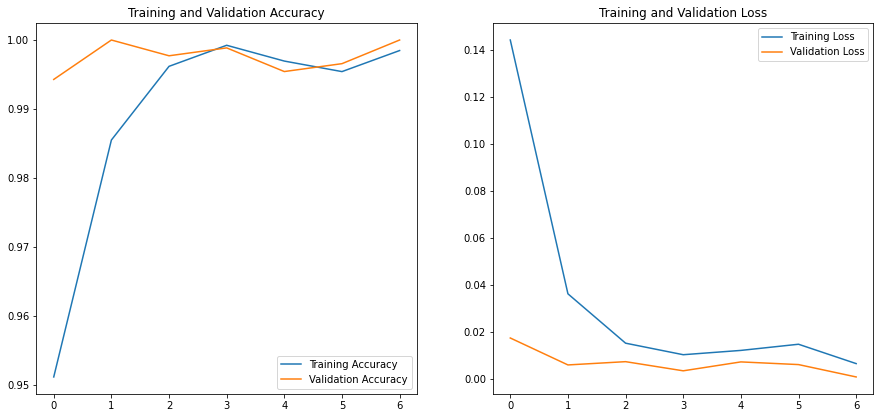

In [ ]:
#Plot model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict uploaded image

Saving download.jpeg to download (2).jpeg


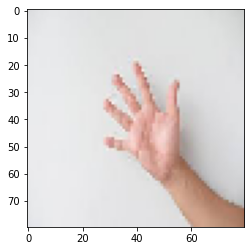


This image most likely belongs to: 

====== PAPER ====== 



,Class,Prob
0,paper,0.9300
1,rock,0.0214
2,scissors,0.0486


In [ ]:
uploaded = files.upload()
 
for fn in uploaded.keys():
  path = fn
  img = load_img(path, target_size=(IMG_SIZE,IMG_SIZE))
  imgplot = plt.imshow(img)
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

labels = list(validation_generator.class_indices)
score = model.predict(img/255.0)

plt.show()
print('\nThis image most likely belongs to: \n\n====== {} ====== \n'
    .format(labels[np.argmax(score)].upper()))

df = {'Class': labels, 
     'Prob': [ '%.4f' % num for num in score.tolist()[0] ]}
pd.DataFrame(df)